In [1]:
using Plots
using PLAYA
using Statistics
using UnicodeFun # to_latex
using DifferentialEquations
using DiffEqSensitivity
# using ODEInterfaceDiffEq # radau
using Catalyst

# Setup

In [2]:
# parse BOLOS output
bolos_interpolations = parse_bolos_output("../assets/air-kinetics-bolos.dat")

Loaded Mean energy from BOLOS file
Loaded Mobility *N from BOLOS file
Loaded Diffusion coefficient *N from BOLOS file
Loaded N2O->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded O2(a1)->None from BOLOS file
Loaded O->None from BOLOS file
Loaded N2->None from BOLOS file
Loaded N->None from BOLOS file
Loaded O3->None from BOLOS file
Loaded O2->None from BOLOS file
Loaded N2O->N2O^- from BOLOS file
Loaded N2O->N2O^+ from BOLOS file
Loaded N2O->N2O(V2)(0.073eV) from BOLOS file
Loaded N2O->N2O(V3)(0.159eV) from BOLOS file
Loaded N2O->N2O(V1)(0.276eV) from BOLOS file
Loaded N2O->N2O(e1)(4.05eV) from BOLOS file
Loaded N2O->N2O(e2)(8.5eV) from BOLOS file
Loaded N2O->N2O(e3)(9.6eV) from BOLOS file
Loaded NO->O^-+N from BOLOS file
Loaded NO->NO(ionization) from BOLOS file
Loaded NO->NO^+ from BOLOS file
Loaded NO->N+O^+ from BOLOS file
Loaded NO->N^++O from BOLOS file
Loaded NO->NO++ from BOLOS file
Loaded NO->NO(a4PI) f

Dict{AbstractString,Interpolations.GriddedInterpolation{Float64,1,Float64,Interpolations.Gridded{Interpolations.Linear},Tuple{Array{Float64,1}}}} with 87 entries:
  "NO->NO(A2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v3)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "NO->NO(D2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N->N^+"                => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->None"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v6)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v4)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O2(v1res)"         => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->O2^+"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O^-+O"             => 200-element interpolate((::Array{Float64,1},), ::A…
  "O->O(1D)"              =

In [3]:
EN = 200. # Townsend
Tgas = 300.
Te = bolos_interpolations["Mean energy"](EN) * 1.1604505e4  # Temperature of electrons in K
dTion  = 2.0e0 / ( 3.0e0 * 1.3807e-16 ) * 1.6605e-24 * ( 1.0e-17 * EN )^2
TionN  = Tgas + dTion * 14.0e0 * 8.0e19^2
TionN2 = Tgas + dTion * 28.0e0 * 4.1e19^2
TionN3 = Tgas + dTion * 42.0e0 * 6.1e19^2
TionN4 = Tgas + dTion * 56.0e0 * 7.0e19^2
TeffN  = ( TionN  + 0.5e0 * Tgas ) / ( 1.0e0 + 0.5e0 )
TeffN2 = ( TionN2 + 1.0e0 * Tgas ) / ( 1.0e0 + 1.0e0 )
TeffN3 = ( TionN3 + 1.5e0 * Tgas ) / ( 1.0e0 + 1.5e0 )
TeffN4 = ( TionN4 + 2.0e0 * Tgas ) / ( 1.0e0 + 2.0e0 )
Teff3Q = 46.501347e-27*((1.87e-4*(1.0e5/(273.0*1.38064e-23))*( 1.0e-21 * EN ))^2)/(3.0e0*1.38064e-23) + Tgas

globals = Dict{Symbol, Any}([
                :E => EN,
                :Te => Te,
                :Tgas => Tgas,
                :dTion   => dTion,
                :TionN   => TionN,
                :TionN2  => TionN2,
                :TionN3  => TionN3,
                :TionN4  => TionN4,
                :TeffN   => TeffN,
                :TeffN2  => TeffN2,
                :TeffN3  => TeffN3,
                :TeffN4  => TeffN4,
                :Teff3Q  => Teff3Q,
               ])

# create functions that will get evaluated to rates
globals[:BOLOS] = (id, env) -> bolos_interpolations[id](env[:E])

println(globals)

Dict{Symbol,Any}(:TionN2 => 1809.503179546607,:dTion => 3.2070688781053097e-38,:TeffN3 => 2304.828553632216,:Te => 63815.573943526564,:TeffN4 => 3233.39900050699,:E => 200.0,:TionN4 => 9100.19700152097,:TeffN => 2215.689143188238,:Teff3Q => 1405.4034963438025,:TionN3 => 5312.07138408054,:BOLOS => var"#1#2"(),:TionN => 3173.5337147823575,:TeffN2 => 1054.7515897733035,:Tgas => 300.0)


In [4]:
# replace stuff so it is Catalyst-compliant
replacements = [
                "^+" => to_latex("^+"),
                "^-" => to_latex("^-"),
                "(" => to_latex("\\llcorner"),
                ")" => to_latex("\\lrcorner"),
                "4.5eV" => to_latex("4°5eV"),
                "`" => to_latex("\\tilde"),
                "=>" => "-->",
    ]

7-element Array{Pair{String,String},1}:
    "^+" => "⁺"
    "^-" => "⁻"
     "(" => "⌞"
     ")" => "⌟"
 "4.5eV" => "4°5eV"
     "`" => "̃"
    "=>" => "-->"

In [12]:
# parse the reaction file
(rs, ps) = parse_reactions("../assets/simple.reactions", globals; to_replace=replacements)

1.1096030276599076e-16 *1e6
2.8493172592219414e-16 *1e6
p1, e + N      --> e + e + N⁺    # BOLOS {N -> N⁺} *1e6
p2, e + O      --> e + e + O⁺    # BOLOS {O -> O⁺ ⌞ioniz⌟} *1e6
p3, e + N⁺ + ANY_NEUTRAL --> N + ANY_NEUTRAL    # 6.0e-27 * ⌞300.0e0/Te⌟^1.5
p4, e + O⁺ + ANY_NEUTRAL --> O + ANY_NEUTRAL    # 6.0e-27 * ⌞300.0e0/Te⌟^1.5


(ReactionSystem(Reaction[Reaction{Variable,Int64}(p1, Operation[e(t), N(t)], Operation[e(t), N⁺(t)], [1, 1], [2, 1], Pair{Variable,Int64}[N⁺ => 1, e => 1, N => -1], false), Reaction{Variable,Int64}(p2, Operation[e(t), O(t)], Operation[e(t), O⁺(t)], [1, 1], [2, 1], Pair{Variable,Int64}[O⁺ => 1, O => -1, e => 1], false), Reaction{Variable,Int64}(p3, Operation[e(t), N⁺(t), ANY_NEUTRAL(t)], Operation[N(t), ANY_NEUTRAL(t)], [1, 1, 1], [1, 1], Pair{Variable,Int64}[N⁺ => -1, e => -1, N => 1], false), Reaction{Variable,Int64}(p4, Operation[e(t), O⁺(t), ANY_NEUTRAL(t)], Operation[O(t), ANY_NEUTRAL(t)], [1, 1, 1], [1, 1], Pair{Variable,Int64}[O⁺ => -1, O => 1, e => -1], false)], t, Variable[e, N, N⁺, O, O⁺, ANY_NEUTRAL], Variable[p1, p2, p3, p4], Variable[], Equation[], Symbol("##ReactionSystem#387"), ReactionSystem[]), [1.1096030276599076e-10, 2.8493172592219414e-10, 1.933940521326045e-30, 1.933940521326045e-30])

# Create the system of ODEs

In [21]:
# initial conditions
n_gas = 2.5e19
conc = Dict(["e" => 1e12, "N" => 0.8*n_gas, "O" => 0.2*n_gas, "ANY_NEUTRAL" => n_gas])
u0 = [ get(conc, string(s), 0.) for s in species(rs) ]
tspan = (0., 0.2)

odesys = convert(ODESystem, rs)

# Keep electrons and neutrals fixed
keep_fixed!(odesys, "e")
keep_fixed!(odesys, "ANY_NEUTRAL")
keep_fixed!(odesys, "N")
keep_fixed!(odesys, "O")

Equation(derivative(O(t), t), identity(0))

In [22]:
prob = ODEProblem(odesys, u0, tspan, ps)
print("Solving....")
sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

Solving....

retcode: Success
Interpolation: 3rd order Hermite
t: 68-element Array{Float64,1}:
 0.0
 1.0e-6
 5.270427332781364e-6
 2.7154293666356733e-5
 0.00012072435239601271
 0.00032090010475262925
 0.0006095836905829503
 0.0009792067177753511
 0.001447374342919418
 0.0020120938969114977
 0.0026792684434006468
 0.0034466999614035576
 0.004314098706251782
 ⋮
 0.12132679212345586
 0.12668220683010453
 0.1323021899468648
 0.1382127553478524
 0.1444439022871934
 0.1510304555775524
 0.15801312560292202
 0.16543988308364163
 0.17336774011946507
 0.1818651156205689
 0.19101499668442182
 0.2
u: 68-element Array{Array{Float64,1},1}:
 [1.0e12, 2.0e19, 0.0, 5.0e18, 0.0, 2.5e19]
 [1.000000000000001e12, 2.0e19, 2.2191524085279562e15, 5.0e18, 1.4246241901028418e15, 2.5e19]
 [9.999999999999989e11, 2.0e19, 1.1694674184957828e16, 5.0e18, 7.507603207079295e15, 2.5e19]
 [9.999999999999996e11, 2.0e19, 6.022143283450248e16, 5.0e18, 3.866021533671748e16, 2.5e19]
 [1.0000000000000062e12, 2.0e19, 2.6713185212792813e17,

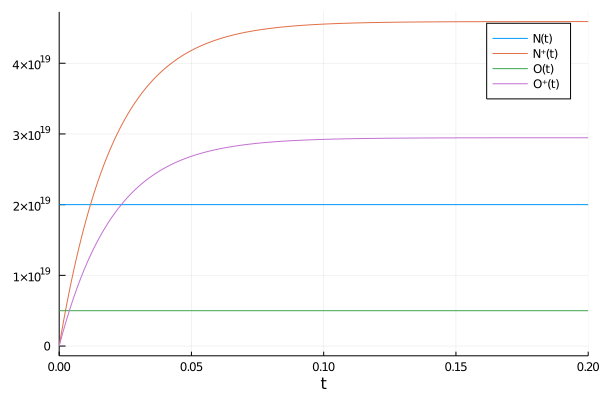

In [27]:
plot(sol, vars=(0,2))
plot!(sol, vars=(0,3))
plot!(sol, vars=(0,4))
plot!(sol, vars=(0,5))

# Sensitivity analysis

Based on [DifferentialEquations tutorial](https://diffeq.sciml.ai/stable/analysis/global_sensitivity/)

In [28]:
f1 = function (p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1,Rodas5();
              saveat=range(tspan[2]/10., stop=tspan[2], length=100),
              reltol=1e-8,
              abstol=1e-8,
             )
  mean(sol[3,:])/mean(sol[5,:])
end

bounds = [ [0.5*i, 1.5*i] for i in ps ]
m = gsa(f1, Morris(total_num_trajectory=1000, num_trajectory=150), bounds)

DiffEqSensitivity.MorrisResult{Array{Float64,2},Array{Any,1}}([1.6052526869528055e10 -7.435167745379451e9 -9.300260556067672e29 8.263190327865018e29], [1.6052526869528055e10 7.435167745379451e9 9.300260556067672e29 8.263190327865018e29], [5.8638807255151985e19 3.991668617616627e19 3.8243046713845703e59 1.8059137364874542e59], Any[[2.355504122662053e10, 2.463389875761713e10, 2.255645466319282e10, 2.255645466319282e10, 9.67857840969909e9, 9.670102184918694e9, 1.1682143970841578e10, 1.1582195875090942e10, 9.639386832533476e9, 9.43356365361816e9  …  6.336737699934868e9, 6.336738316410163e9, 1.874824575213183e10, 1.874824575213183e10, 1.8914050014632225e10, 1.9242990569680676e10, 9.413077331505999e9, 9.324785239210867e9, 9.324785011275263e9, 9.32478568844129e9], [-1.896985877629103e10, -1.8407789206378345e10, -1.7870334645464287e10, -1.8006231291935726e10, -1.8547772592851913e10, -1.91141157354388e10, -1.955807130069777e10, -6.343649569771112e9, -6.212175217721694e9, -6.084745794434436e9  …

In [30]:
# output most significant reactions
inds = sortperm(m.means[1,:])
for i in reverse(inds)[1:4]
    r =  rs.eqs[i]
    f = x-> join(map(string, x), " + ")
    println(f(r.substrates), " => ", f(r.products), ":  μ = $(m.means[i]),  σ = $(m.variances[i])")
end

e(t) + O⁺(t) + ANY_NEUTRAL(t) => O(t) + ANY_NEUTRAL(t):  μ = 8.263190327865018e29,  σ = 1.8059137364874542e59
e(t) + N(t) => e(t) + N⁺(t):  μ = 1.6052526869528055e10,  σ = 5.8638807255151985e19
e(t) + O(t) => e(t) + O⁺(t):  μ = -7.435167745379451e9,  σ = 3.991668617616627e19
e(t) + N⁺(t) + ANY_NEUTRAL(t) => N(t) + ANY_NEUTRAL(t):  μ = -9.300260556067672e29,  σ = 3.8243046713845703e59
